## Imports ##

In [1]:
import numpy as np
import plotly.express as px
from matplotlib.dates import DateFormatter
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
from tqdm.notebook import tqdm
import ast

%load_ext autoreload
%autoreload 2
plt.style.use('ggplot')

## NLP Models ##

### DistilRoBERTa Financial Sentiment Model ###

A fine-tuned version of DistilRoberta base model on the Financial PhraseBank dataset.

https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

In [2]:
model_DistRoBERTa = f"mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"


_sentiment_analysis_DistRoBERTa = pipeline("sentiment-analysis",
                                           model= AutoModelForSequenceClassification.from_pretrained(
                                               model_DistRoBERTa,
                                               num_labels=3),
                                           tokenizer=AutoTokenizer.from_pretrained(model_DistRoBERTa),
                                           top_k=None, padding=True, truncation=True
                                           )

### FinBERT ###

A pre-traned NLP model to analyze sentiment of financial text.
The BERT model fine-tuned on the Financial PhraseBank dataset.

https://huggingface.co/ProsusAI/finbert

In [3]:
model_FinBERT = "ProsusAI/finbert"
_sentiment_analysis_FinBERT = pipeline("sentiment-analysis",
                                       model=AutoModelForSequenceClassification.from_pretrained(
                                           model_FinBERT,
                                           num_labels=3
                                       ),
                                       tokenizer=AutoTokenizer.from_pretrained(model_FinBERT),
                                       top_k=None, padding=True, truncation=True
                                       )

### FinDeBERTa ###

A fine-tuned version of DeBERTa base model on the None dataset.

https://huggingface.co/mrm8488/deberta-v3-ft-financial-news-sentiment-analysis

In [4]:
model_DeBERTa = f"mrm8488/deberta-v3-ft-financial-news-sentiment-analysis"
_sentiment_analysis_DeBERTa = pipeline("sentiment-analysis",
                                       model=AutoModelForSequenceClassification.from_pretrained(
                                           model_DeBERTa,
                                           num_labels=3),
                                       tokenizer=AutoTokenizer.from_pretrained(model_DeBERTa),
                                       top_k=None, padding=True)

## Functions ##

#### Preprocess Data ####

In [5]:
def preprocess_data(input_file, output_file, debug=False):
    """
    Process stock data.

    Parameters:
    - input_file: Path to the input CSV file.
    - output_file: Path to save the processed CSV file.
    """
    try:
        # Read the CSV file
        data = pd.read_csv(input_file)

        # Drop any columns containing 'unnamed' (in case of unnamed index columns)
        data.drop(data.columns[data.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

        # Save the processed data to a CSV file
        data.to_csv(output_file, index=False)
        print(f"Processed data saved to {output_file}")

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
    except ValueError as ve:
        print(f"Error: {ve}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

#### Sentiment Scores ####

In [6]:
def get_sentiment_scores_test(df, news, model, debug=False):
    """
    Performs sentiment analysis using a specified pipeline and calculates sentiment scores.

    Args:
        df (pd.DataFrame): DataFrame containing the text data.
        news (str): Column name for the news headlines or text to analyze.
        model (str): The model to use for sentiment analysis ('DistRoBERTa', 'FinBERT', 'DeBERTa').
        debug (bool): If True, logs details of failures.

    Returns:
        pd.DataFrame: DataFrame with calculated sentiment scores.
    """
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    df = df.copy()

    # Select the appropriate model pipeline
    if model == "DistRoBERTa":
        sent_pipeline = _sentiment_analysis_DistRoBERTa
    elif model == "FinBERT":
        sent_pipeline = _sentiment_analysis_FinBERT
    elif model == "DeBERTa":
        sent_pipeline = _sentiment_analysis_DeBERTa
    else:
        raise ValueError("Invalid model name. Choose 'DistRoBERTa', 'FinBERT', 'DeBERTa'.")

    res = {}
    fail = {}
    n = 0

    # Process each row in the DataFrame
    for i, row in tqdm(df.iterrows(), total=len(df)):
        text = row[news]
        try:
            if pd.isna(text):
                roberta_result = [[
                    {'label': 'neutral', 'score': 1.0},
                    {'label': 'negative', 'score': 0},
                    {'label': 'positive', 'score': 0}
                ]]
            else:
                roberta_result = sent_pipeline(text)

        except (IndexError, RuntimeError):
            if pd.isna(text) and debug:
                fail[n] = str(i)
            elif debug:
                fail[n] = text
                n += 1
            roberta_result = [[
                {'label': 'neutral', 'score': 1.0},
                {'label': 'negative', 'score': 0},
                {'label': 'positive', 'score': 0}
            ]]
            pass
        res[i] = roberta_result[0]  # Extract the first list

    # Create a new column with the sentiment score
    sentiment_score_col = f"{model}_sentiment_scores"
    df[sentiment_score_col] = res

    if debug:
        return df, fail
    else:
        return df

In [7]:
def get_sentiment_scores_thread(df, news_column, model, debug=False):
    """
    Performs CPU-optimized sentiment analysis on news text and calculates sentiment scores.

    Args:
        df (pd.DataFrame): DataFrame containing the news data
        news_column (str): Name of the column containing news text
        model (str): Model name ('DistRoBERTa', 'FinBERT', or 'DeBERTa')

    Returns:
        pd.DataFrame: Original DataFrame with added sentiment score column
    """
    df = df.copy()

    pipelines = {
        "DistRoBERTa": _sentiment_analysis_DistRoBERTa,
        "FinBERT": _sentiment_analysis_FinBERT,
        "DeBERTa": _sentiment_analysis_DeBERTa
    }

    pipe = pipelines.get(model)
    if not pipe:
        raise ValueError(f"Invalid model. Choose from: {', '.join(pipelines.keys())}")

    DEFAULT_SENTIMENT = [[{
        'label': 'negative', 'score': 0
    }, {
        'label': 'neutral', 'score': 1
    }, {
        'label': 'positive', 'score': 0
    }]]

    from concurrent.futures import ThreadPoolExecutor
    from functools import partial

    def process_single_text(text, pipe=pipe):
        """Process a single text item"""
        if pd.isna(text) or not str(text).strip():
            return DEFAULT_SENTIMENT

        try:
            result = pipe(text)
            return result if isinstance(result, list) else [result]
        except:
            return DEFAULT_SENTIMENT

    # Process texts using thread pool
    texts = df[news_column].values
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers based on your CPU
        all_sentiments = list(tqdm(
            executor.map(process_single_text, texts),
            total=len(texts),
            desc=f"Processing {model} sentiment"
        ))

    def calculate_score(result):
        """Calculate sentiment score from result"""
        result = result[0]
        pos_score = next((item['score'] for item in result if item['label'] == 'positive'), 0)
        neg_score = next((item['score'] for item in result if item['label'] == 'negative'), 0)
        denominator = pos_score + neg_score
        return (pos_score - neg_score) / denominator if denominator > 0 else 0

    # Calculate scores and add to DataFrame
    df[f"{model}_sentiment_score"] = [calculate_score(result) for result in all_sentiments]

    return df

In [8]:
def sentiment_vector(df, scores, model, debug=False):
    """
    Creates a sentiment vector column based on sentiment scores.
    (Neutral, Positive, Negative)

    Parameters:
    - df: DataFrame containing the stock data.
    - scores: Column name for the sentiment scores.
    - model: Name of the model.
    - debug: If True, prints debugging information.
    """
    df = df.copy()

    # Function to extract scores and create a sentiment vector
    def extract_scores(row):
        # If row is a string, convert it to a Python object
        if isinstance(row, str):
            row = ast.literal_eval(row)  # Safely evaluate the string to a Python object
        # Extract scores for neutral, positive, and negative in the correct order
        dimensions = {item['label']: item['score'] for item in row}
        return dimensions['neutral'], dimensions['positive'], dimensions['negative']

    # Apply the function to the column
    sentiment_vector_col = f"{model}_sentiment_vector"
    df[sentiment_vector_col] = df[scores].apply(extract_scores)

    if debug:
        print(f"Sentiment vector column '{sentiment_vector_col}' created successfully.")
        print(df[sentiment_vector_col].head())

    return df


In [36]:
def adjust_scores(df, vectors, model, debug=False):
    """Calculate adjusted sentiment scores from vector column."""
    df = df.copy()

    def calculate_normalized_score(vector):
        neutral, positive, negative = vector
        total = positive + negative #+ neutral
        return (positive - negative) / total if total > 0 else 0

    def calculate_raw_score(vector):
        neutral, positive, negative = vector
        return positive if positive > negative else (-1*negative) if negative > positive else 0


    df[f"{model}_adjusted_score"] = df[vectors].apply(calculate_normalized_score)
    df[f"{model}_raw_score"] = df[vectors].apply(calculate_raw_score)

    if debug:
        print(f"Adjusted scores distribution:\n{df[f'{model}_adjusted_score'].describe()}")

    return df

#### Validate Predictions ####

In [27]:
def validate_predictions(df, tar, sco, vol, model, target_factor=0.1, score_factor = 0.33, debug=False):
    """
    Validate prediction based on adaptive volatility-based threshold for neutrality.

    Args:
        df (pd.DataFrame): DataFrame containing stock data with calculated volatility.
        tar (str): Column name for the target price change (e.g., 'Daily Return').
        sco (str): Column name for the sentiment score.
        model (str): Model name to include in the predictions column.
        target_factor (float): Multiplier for volatility to define the neutral threshold for the target.
        score_factor (float): Threshold for neutral sentiment score.
        debug (bool): If True, logs details of failures.

    Returns:
        pd.DataFrame: DataFrame with predictions and success/failure of predictions.
    """
    predict_dict = {}
    fail = {}
    n = 0

    # Validate input columns exist
    required_cols = [tar, sco, vol]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    # Calculate adaptive volatility threshold and predictions
    for i, row in tqdm(df.iterrows(), total=len(df), disable=not debug):
        try:
            target = row[tar]
            score = row[sco]

            # Handle NaN values
            if pd.isna(target) or pd.isna(score) or pd.isna(row[vol]):
                predict_dict[i] = 0  # or another default value for NaN cases
                continue


            neu_target_threshold = abs(row[vol] * target_factor) if abs(row[vol] * target_factor) <= 1 else 1 # Add abs() for safety

            #neu_score_threshold = abs(row[vol] * score_factor) if abs(row[vol] * score_factor) <= 1 else 1 # Add abs() for safety
            neu_score_threshold = score_factor

            # Improved prediction logic
            if abs(target) > neu_target_threshold and abs(score) > neu_score_threshold:
                # Only evaluate directional accuracy when both target and score are non-zero
                if target != 0 and score != 0:
                    predict_dict[i] = 1 if (target * score) > 0 else 0  # Simplified comparison
                else:
                    predict_dict[i] = 0  # Case where either value is zero
            else:
                # Modified neutral case logic
                predict_dict[i] = 1 if abs(score) < neu_score_threshold and abs(target) < neu_target_threshold else 0

        except KeyError as e:
            if debug:
                print(f"KeyError at index {i}: {str(e)}")
            predict_dict[i] = 0
        except Exception as e:
            if debug:
                fail[n] = {'index': i, 'error': str(e)}
                n += 1
            predict_dict[i] = 0

    # Create the predictions DataFrame more efficiently
    predictions = pd.Series(predict_dict, name=f"{model}_predictions")

    # Update the DataFrame more efficiently
    if predictions.name in df.columns:
        df = df.drop(columns=[predictions.name])
    df = df.join(predictions)

    if debug:
        return df, fail
    else:
        return df

In [11]:
def add_trend(df, close, day=1, debug=False):
    """
    Calculates the trend of a stock price.

    Parameters:
    - df: DataFrame containing the stock data.
    - close: Column name for the close price.
    - day: Number of days to calculate the trend.
    """
    try:
        # Calculate the trend
        tend_col = f"trend_{day}d"
        df[tend_col] = df[close].pct_change(periods=day).shift(-1)

        if debug:
            return df
        else:
            return df

    except KeyError as e:
        if debug:
            print(f"KeyError: {str(e)}")
            return df
        else:
            return df

In [12]:
def add_volatility(df, close, window=5, trading_days=252, debug=False):
    """
    Calculate rolling volatility for a DataFrame's close price column.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing price data
    close : str
        Name of the column containing closing prices
    window : int, optional
        Rolling window size for volatility calculation (default: 5)
    trading_days : int, optional
        Annual trading days for annualized volatility (default: 252)
    debug : bool, optional
        If True, returns additional debug information (default: False)

    Returns:
    --------
    pandas.DataFrame
        Original DataFrame with added volatility columns
    """
    # Create a copy of the DataFrame to avoid modifying the original
    result = df.copy()

    # Calculate log returns
    result['log_returns'] = np.log(result[close] / result[close].shift(1))

    # Calculate rolling standard deviation of log returns (annualized)
    result[f'volatility_{window}d'] = (
        result['log_returns']
        .rolling(window=window)
        .std()
        * np.sqrt(trading_days)
    )

    # Optional debug information
    if debug:
        result['rolling_mean'] = result['log_returns'].rolling(window=window).mean()
        result['rolling_variance'] = result['log_returns'].rolling(window=window).var()

    return result

#### Plot ####

In [13]:
def create_sentiment_plot(df, data_name, size=4, debug=False):
    fig = go.Figure()

    # Define color schemes for each model: (true_color, false_color)
    color_schemes = {
        'DistRoBERTa': ('#2ecc71', '#a9dfbf'),  # Green shades
        'FinBERT': ('#3498db', '#aed6f1'),      # Blue shades
        'DeBERTa': ('#9b59b6', '#d7bde2')       # Purple shades
    }

    sentiment_models = [
        ('DistRoBERTa', 'DistRoBERTa_adjusted_score', 'DistRoBERTa_predictions'),
        ('FinBERT', 'FinBERT_adjusted_score', 'FinBERT_predictions'),
        ('DeBERTa', 'DeBERTa_adjusted_score', 'DeBERTa_predictions')
    ]

    for model_name, score_col, pred_col in sentiment_models:
        # Get color scheme for this model
        true_color, false_color = color_schemes[model_name]

        # Create scatter plot for each prediction value (0 and 1)
        for pred_value in [0, 1]:
            mask = df[pred_col] == pred_value

            fig.add_trace(
                go.Scatter(
                    x=df[mask]['Date'],
                    y=df[mask][score_col],
                    name=f'{model_name} (Prediction={pred_value.__bool__()})',
                    mode='markers',  # Removed 'lines' to show only markers
                    marker=dict(
                        color=true_color if pred_value == 1 else false_color,
                        size=10,
                        symbol='circle'
                    )
                )
            )

    fig.update_layout(
        title=f'{data_name} Sentiment Scores Over Time by Model',
        xaxis_title='Date',
        yaxis_title='Sentiment Score',
        template='plotly_white',
        hovermode='x unified',
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True)
    )
    fig.update_traces(marker=dict(size=size))
    return fig

In [90]:
def plot_sentiment_and_stock(sentiment_plot, model_name, stock_plot, close):
    """
    Plot sentiment scores (adjusted and raw) and stock price changes over time.

    Parameters:
    - sentiment_plot: DataFrame containing sentiment data.
    - model_name: String, name of the sentiment analysis model (e.g., 'DeBERTa').
    - stock_plot: DataFrame containing stock data.
    - close_diff_col: String, column name for the stock's price differences.
    """
    something_unique, ax1 = plt.subplots(figsize=(22, 6))

    # Plot adjusted sentiment score moving average
    adjusted_score_col = f"{model_name}_adjusted_score_ma"
    ax1.plot(sentiment_plot.index, sentiment_plot[adjusted_score_col], color='blue', label=f'{model_name} Adjusted Score MA')
    ax1.set_title(f'{model_name} Sentiment Scores Over Time by Model')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Adjusted Sentiment Score', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
    ax1.xaxis.set_major_formatter(DateFormatter('%y-%m-%d'))

    # Add stock price change on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(stock_plot.index, stock_plot[close], color='red', label='Close Price Change')
    ax2.set_ylabel('Price Change', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Add raw sentiment score moving average on another y-axis
    ax3 = ax1.twinx()
    raw_score_col = f"{model_name}_raw_score_ma"
    ax3.plot(sentiment_plot.index, sentiment_plot[raw_score_col], color='orange', label=f'{model_name} Raw Score MA')
    ax3.set_ylabel('Raw Sentiment Score', color='orange')
    ax3.tick_params(axis='y', labelcolor='orange')

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    lines3, labels3 = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + lines3, labels1 + labels2 + labels3, loc='upper left', fontsize=12)

    plt.show()

#### Unused ####

In [14]:
def find_best_threshold(data, score_column, prediction_column, model_name, start_threshold=0, end_threshold=1, min_increment=0.01):
    """
    Optimized function to find the best threshold for sentiment score predictions using iterative refinement.

    Args:
        data (pd.DataFrame): The DataFrame containing the stock and sentiment data.
        score_column (str): The name of the column containing sentiment scores.
        prediction_column (str): The name of the column containing prediction values (0 or 1).
        model_name (str): The name of the sentiment model used.
        start_threshold (float): The starting threshold (default is 0).
        end_threshold (float): The ending threshold (default is 1).
        min_increment (float): The minimum increment to consider (default is 0.01).

    Returns:
        tuple: The best threshold and the corresponding score.
    """
    def evaluate_threshold(threshold):
        """Helper function to evaluate a single threshold value"""
        temp_data = validate_predictions(data.copy(), 'Target', score_column, model_name, threshold)
        return sum(temp_data[prediction_column]) / len(temp_data.index)

    best_threshold = start_threshold
    best_score = 0.0
    current_start = start_threshold
    current_end = end_threshold

    # Continue refining until the increment becomes too small
    refinement_level = 1
    while True:
        # Calculate current increment as 10% of current range
        current_increment = (current_end - current_start) * 0.1

        # Stop if increment becomes too small
        if current_increment <= min_increment:
            # Final fine-tuning with minimum increment
            final_range = np.arange(current_start, current_end + min_increment, min_increment)
            for threshold in tqdm(final_range,
                                desc=f"Final refinement (increment={min_increment:.4f})",
                                leave=True):
                current_score = evaluate_threshold(threshold)
                if current_score > best_score:
                    best_score = current_score
                    best_threshold = threshold
            break

        # Create threshold range for this iteration
        thresholds = np.arange(current_start, current_end + current_increment, current_increment)

        # Evaluate each threshold in the current range
        local_best_threshold = best_threshold
        local_best_score = best_score

        for threshold in tqdm(thresholds,
                            desc=f"Refinement level {refinement_level} (increment={current_increment:.4f})",
                            leave=True):
            current_score = evaluate_threshold(threshold)
            if current_score > local_best_score:
                local_best_score = current_score
                local_best_threshold = threshold

        # Update best overall if better found
        if local_best_score > best_score:
            best_score = local_best_score
            best_threshold = local_best_threshold

        # Update range for next iteration
        # New range is ±10% around the best threshold found
        range_width = current_increment * 2  # Look one increment on either side
        current_start = max(start_threshold, best_threshold - range_width)
        current_end = min(end_threshold, best_threshold + range_width)

        refinement_level += 1

    return best_threshold, best_score

## Prepare Data ##

In [19]:
# preprocess_data('/tmp/pycharm_project_520/src/data/input/raw/source_1/AppleNewsStock.csv', '/tmp/pycharm_project_520/src/data/input/processed/source_1/AppleNewsStock_new.csv')
# preprocess_data('/tmp/pycharm_project_520/src/data/input/raw/source_1/MicrosoftNewsStock.csv', '/tmp/pycharm_project_520/src/data/input/processed/source_1/MicrosoftNewsStock_new.csv')

In [ ]:
aapl_data = pd.read_csv('/tmp/pycharm_project_520/src/data/input/processed/source_1/AppleNewsStock_new.csv')
aapl_data.plot.line(y="Adj Close", x='Date')

In [ ]:
msft_data = pd.read_csv('/tmp/pycharm_project_520/src/data/input/processed/source_1/MicrosoftNewsStock_new.csv')
msft_data.plot.line(y="Adj Close", x='Date')

# Sentiment Analysis

### -Microsoft

In [22]:
msft_data = add_trend(msft_data, "Adj Close")

In [39]:
msft_data = add_volatility(msft_data, 'Adj Close')

<Axes: xlabel='Date'>

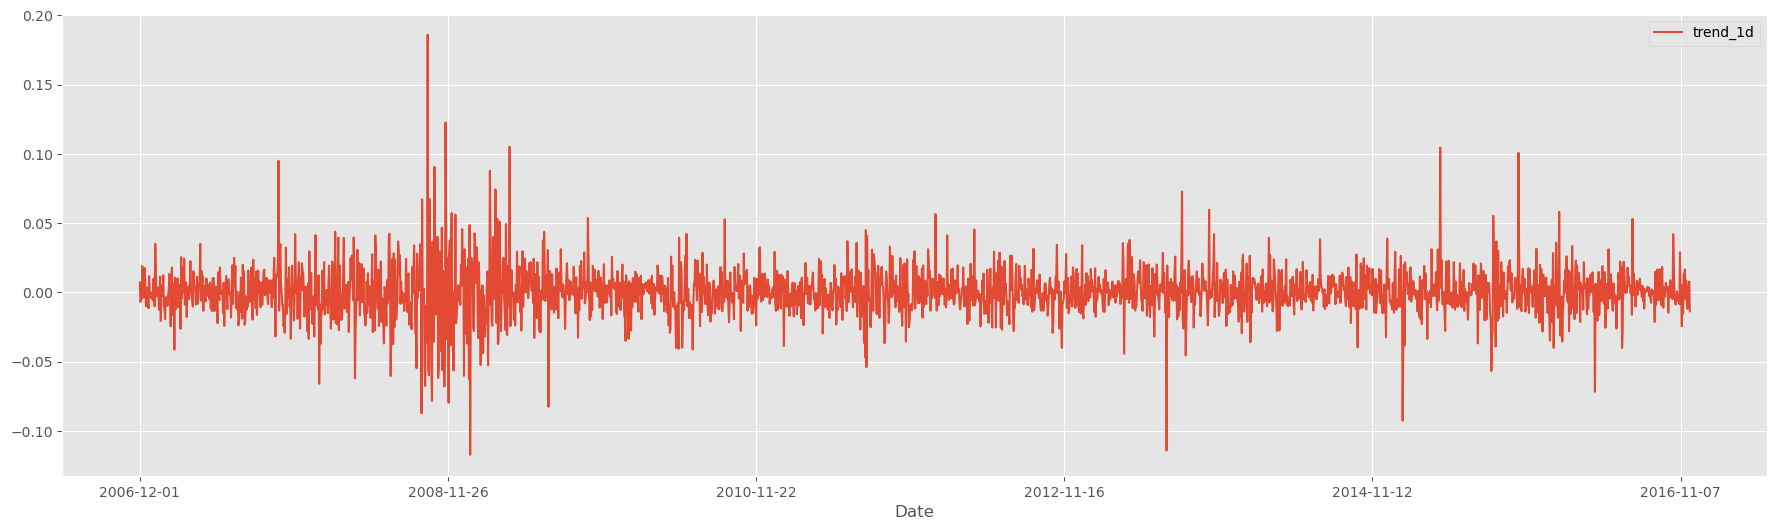

In [133]:
msft_data.plot.line(y="trend_1d", x='Date', figsize=(22, 6))

In [24]:
msft_data = get_sentiment_scores_test(msft_data, 'News', model="DistRoBERTa")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [25]:
msft_data = get_sentiment_scores_test(msft_data, 'News', model="FinBERT")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [26]:
msft_data = get_sentiment_scores_test(msft_data, 'News', model="DeBERTa")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [25]:
msft_data = sentiment_vector(msft_data, 'DistRoBERTa_sentiment_scores', "DistRoBERTa")
msft_data = sentiment_vector(msft_data, 'FinBERT_sentiment_scores', "FinBERT")
msft_data = sentiment_vector(msft_data, 'DeBERTa_sentiment_scores', "DeBERTa")

In [37]:
msft_data = adjust_scores(msft_data, 'DistRoBERTa_sentiment_vector', "DistRoBERTa")
msft_data = adjust_scores(msft_data, 'FinBERT_sentiment_vector', "FinBERT")
msft_data = adjust_scores(msft_data, 'DeBERTa_sentiment_vector', "DeBERTa")

In [40]:
msft_data = validate_predictions(msft_data, 'trend_1d', 'DistRoBERTa_adjusted_score', 'volatility_5d', "DistRoBERTa", target_factor=0.15)
msft_data = validate_predictions(msft_data, 'trend_1d', 'FinBERT_adjusted_score', 'volatility_5d', "FinBERT", target_factor=0.15)
msft_data = validate_predictions(msft_data, 'trend_1d', 'DeBERTa_adjusted_score', 'volatility_5d', "DeBERTa", target_factor=0.15)

In [41]:
(sum((msft_data['DistRoBERTa_predictions'])) / len(msft_data.index))

0.5407230830353595

In [42]:
(sum((msft_data['FinBERT_predictions'])) / len(msft_data.index))

0.5208581644815257

In [43]:
(sum((msft_data['DeBERTa_predictions'])) / len(msft_data.index))

0.5085419149781486

In [38]:
msft_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

,DeBERTa_adjusted_score,FinBERT_adjusted_score,DistRoBERTa_adjusted_score,trend_1d
DeBERTa_adjusted_score,1.000000,0.706975,0.725090,0.114709
FinBERT_adjusted_score,0.706975,1.000000,0.571722,0.154048
DistRoBERTa_adjusted_score,0.725090,0.571722,1.000000,0.096931
trend_1d,0.114709,0.154048,0.096931,1.000000


In [39]:
msft_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

,DeBERTa_adjusted_score,FinBERT_adjusted_score,DistRoBERTa_adjusted_score,trend_1d
DeBERTa_adjusted_score,1.000000,0.684045,0.749291,0.111902
FinBERT_adjusted_score,0.684045,1.000000,0.582569,0.139788
DistRoBERTa_adjusted_score,0.749291,0.582569,1.000000,0.071121
trend_1d,0.111902,0.139788,0.071121,1.000000


In [34]:
msft_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

,DeBERTa_raw_score,FinBERT_raw_score,DistRoBERTa_raw_score,trend_1d
DeBERTa_raw_score,1.000000,0.601503,0.720499,0.110354
FinBERT_raw_score,0.601503,1.000000,0.421291,0.088762
DistRoBERTa_raw_score,0.720499,0.421291,1.000000,0.054569
trend_1d,0.110354,0.088762,0.054569,1.000000


In [35]:
msft_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

,DeBERTa_raw_score,FinBERT_raw_score,DistRoBERTa_raw_score,trend_1d
DeBERTa_raw_score,1.000000,0.586941,0.734739,0.097588
FinBERT_raw_score,0.586941,1.000000,0.436500,0.071609
DistRoBERTa_raw_score,0.734739,0.436500,1.000000,0.033600
trend_1d,0.097588,0.071609,0.033600,1.000000


#### Save Data ####

In [131]:
msft_data.to_csv('/tmp/pycharm_project_520/src/data/output/MicrosoftNewsStock_new.csv', index=False)

#### Read Output ####

In [16]:
msft_data = pd.read_csv('/tmp/pycharm_project_520/src/data/output/MicrosoftNewsStock_new.csv')

### -Apple

In [138]:
aapl_data = add_trend(aapl_data, "Adj Close")

In [147]:
aapl_data = add_volatility(aapl_data, 'Adj Close', window=5)

<Axes: xlabel='Date'>

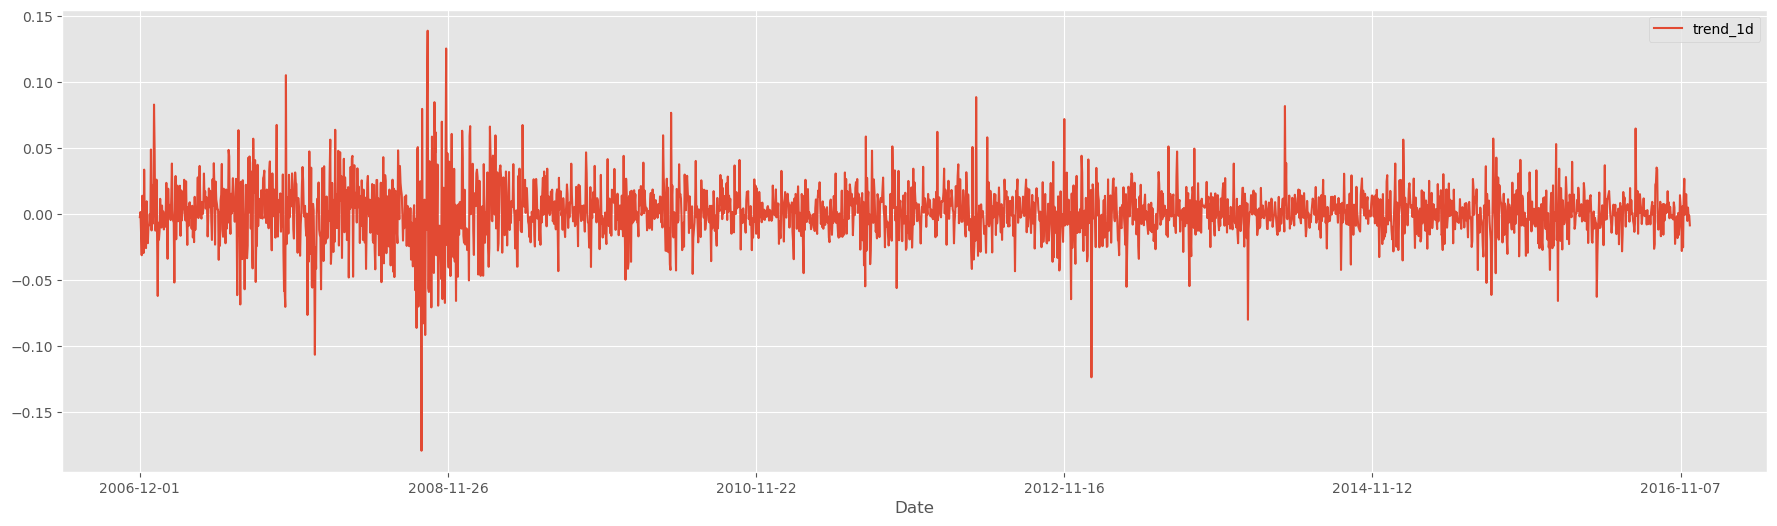

In [132]:
aapl_data.plot.line(y="trend_1d", x='Date', figsize=(22, 6))

In [141]:
aapl_data = get_sentiment_scores_test(aapl_data, 'News', model="DistRoBERTa")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [142]:
aapl_data = get_sentiment_scores_test(aapl_data, 'News', model="FinBERT")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [143]:
aapl_data = get_sentiment_scores_test(aapl_data, 'News', model="DeBERTa")

  0%|          | 0/2517 [00:00<?, ?it/s]

In [99]:
aapl_data = sentiment_vector(aapl_data, 'DistRoBERTa_sentiment_scores', "DistRoBERTa")
aapl_data = sentiment_vector(aapl_data, 'FinBERT_sentiment_scores', "FinBERT")
aapl_data = sentiment_vector(aapl_data, 'DeBERTa_sentiment_scores', "DeBERTa")

In [100]:
aapl_data = adjust_scores(aapl_data, 'DistRoBERTa_sentiment_vector', "DistRoBERTa")
aapl_data = adjust_scores(aapl_data, 'FinBERT_sentiment_vector', "FinBERT")
aapl_data = adjust_scores(aapl_data, 'DeBERTa_sentiment_vector', "DeBERTa")

In [101]:
aapl_data = validate_predictions(aapl_data, 'trend_1d', 'DistRoBERTa_adjusted_score', 'volatility_5d', "DistRoBERTa",
                                 target_factor=0.15)
aapl_data = validate_predictions(aapl_data, 'trend_1d', 'FinBERT_adjusted_score', 'volatility_5d', "FinBERT",
                                 target_factor=0.15)
aapl_data = validate_predictions(aapl_data, 'trend_1d', 'DeBERTa_adjusted_score', 'volatility_5d', "DeBERTa",
                                 target_factor=0.15)

In [102]:
(sum((aapl_data['DistRoBERTa_predictions'])) / len(aapl_data.index))

0.21017083829956298

In [103]:
(sum((aapl_data['FinBERT_predictions'])) / len(aapl_data.index))

0.3694874851013111

In [104]:
(sum((aapl_data['DeBERTa_predictions'])) / len(aapl_data.index))

0.2959872864521255

In [105]:
aapl_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

,DeBERTa_adjusted_score,FinBERT_adjusted_score,DistRoBERTa_adjusted_score,trend_1d
DeBERTa_adjusted_score,1.000000,0.650839,0.783410,0.071518
FinBERT_adjusted_score,0.650839,1.000000,0.660393,0.173787
DistRoBERTa_adjusted_score,0.783410,0.660393,1.000000,0.212258
trend_1d,0.071518,0.173787,0.212258,1.000000


In [106]:
aapl_data[['DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

,DeBERTa_adjusted_score,FinBERT_adjusted_score,DistRoBERTa_adjusted_score,trend_1d
DeBERTa_adjusted_score,1.000000,0.630345,0.780398,0.072393
FinBERT_adjusted_score,0.630345,1.000000,0.647290,0.199732
DistRoBERTa_adjusted_score,0.780398,0.647290,1.000000,0.226027
trend_1d,0.072393,0.199732,0.226027,1.000000


In [107]:
aapl_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr(method='spearman')

,DeBERTa_raw_score,FinBERT_raw_score,DistRoBERTa_raw_score,trend_1d
DeBERTa_raw_score,1.000000,0.346609,0.663966,0.060133
FinBERT_raw_score,0.346609,1.000000,0.498425,0.208071
DistRoBERTa_raw_score,0.663966,0.498425,1.000000,0.217388
trend_1d,0.060133,0.208071,0.217388,1.000000


In [108]:
aapl_data[['DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score', 'trend_1d']].rolling(window=28, center=False).mean().corr()

,DeBERTa_raw_score,FinBERT_raw_score,DistRoBERTa_raw_score,trend_1d
DeBERTa_raw_score,1.000000,0.343613,0.672126,0.034827
FinBERT_raw_score,0.343613,1.000000,0.512255,0.225866
DistRoBERTa_raw_score,0.672126,0.512255,1.000000,0.210860
trend_1d,0.034827,0.225866,0.210860,1.000000


#### Save Data ####

In [130]:
aapl_data.to_csv('/tmp/pycharm_project_520/src/data/output/AppleNewsStock_new.csv', index=False)

#### Read Output ####

In [98]:
aapl_data = pd.read_csv('/tmp/pycharm_project_520/src/data/output/AppleNewsStock_new.csv')

## TO DO ##

Histogram Equalization
3d megbízhatóság számolás

In [ ]:
msft_data['DistRoBERTa_sentiment_score'].hist()

# Plot Result Comparison #

### Plot Sentiment Scores ###

In [ ]:
aapl_fig = create_sentiment_plot(aapl_data, "Apple", size=4)
aapl_fig.show()

In [22]:
msft_fig = create_sentiment_plot(msft_data,"Microsoft" , size=4)
msft_fig.show()

/tmp/ipykernel_2708/908383440.py:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date', 'DeBERTa_sentiment_scores', 'DeBERTa_sentiment_vector',
       'DistRoBERTa_sentiment_scores', 'DistRoBERTa_sentiment_vector',
       'FinBERT_sentiment_scores', 'FinBERT_sentiment_vector', 'News'],
      dtype='object')
  msft_fig = create_sentiment_plot(msft_data.rolling(window=28, center=False).mean(),"Microsoft" , size=4)


KeyError: 'Date'

### Further Operations ###

In [65]:
msft_sentiment_plot = msft_data.loc[:, ['Date', 'DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d', 'DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score']]
msft_sentiment_plot['Date'] = pd.to_datetime(msft_sentiment_plot['Date'])
msft_sentiment_plot.set_index('Date', inplace=True)
msft_sentiment_plot = msft_sentiment_plot.resample('D').mean()
msft_sentiment_plot.fillna(0, inplace=True)

In [125]:
msft_sentiment_plot['DeBERTa_adjusted_score_ma'] = msft_sentiment_plot['DeBERTa_adjusted_score'].rolling(window=90, center=False).mean()
msft_sentiment_plot['FinBERT_adjusted_score_ma'] = msft_sentiment_plot['FinBERT_adjusted_score'].rolling(window=90, center=False).mean()
msft_sentiment_plot['DistRoBERTa_adjusted_score_ma'] = msft_sentiment_plot['DistRoBERTa_adjusted_score'].rolling(window=90, center=False).mean()

msft_sentiment_plot['DeBERTa_raw_score_ma'] = msft_sentiment_plot['DeBERTa_raw_score'].rolling(window=90, center=False).mean()
msft_sentiment_plot['FinBERT_raw_score_ma'] = msft_sentiment_plot['FinBERT_raw_score'].rolling(window=90, center=False).mean()
msft_sentiment_plot['DistRoBERTa_raw_score_ma'] = msft_sentiment_plot['DistRoBERTa_raw_score'].rolling(window=90, center=False).mean()

In [88]:
msft_stock_plot = msft_data.loc[:, ['Date', 'Adj Close']]
msft_stock_plot['Date'] = pd.to_datetime(msft_stock_plot['Date'])
msft_stock_plot.set_index('Date', inplace=True)
msft_stock_plot = msft_stock_plot.resample('D').mean()
msft_stock_plot.fillna(method='ffill', inplace=True)
msft_stock_plot['close_ma'] = msft_stock_plot['Adj Close'].rolling(window=90, center=False).mean()
msft_stock_plot['close_120_ma'] = msft_stock_plot['Adj Close'].rolling(window=120, center=False).mean()
msft_stock_plot['close_252_ma'] = msft_stock_plot['Adj Close'].rolling(window=252, center=False).mean()
msft_stock_plot.dropna(inplace=True)

msft_stock_plot['close_diff'] = msft_stock_plot['Adj Close'] - msft_stock_plot['close_ma']

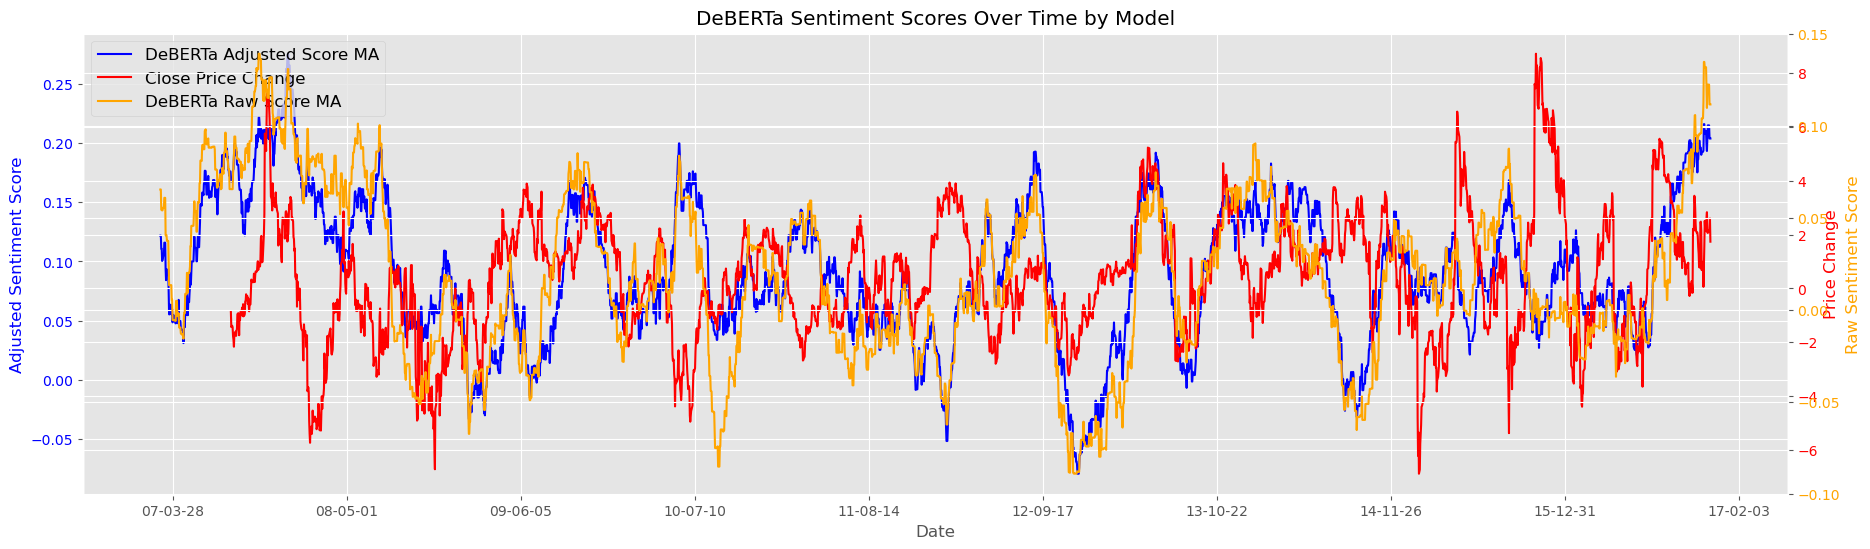

In [91]:
plot_sentiment_and_stock(msft_sentiment_plot, 'DeBERTa', msft_stock_plot, 'close_diff')

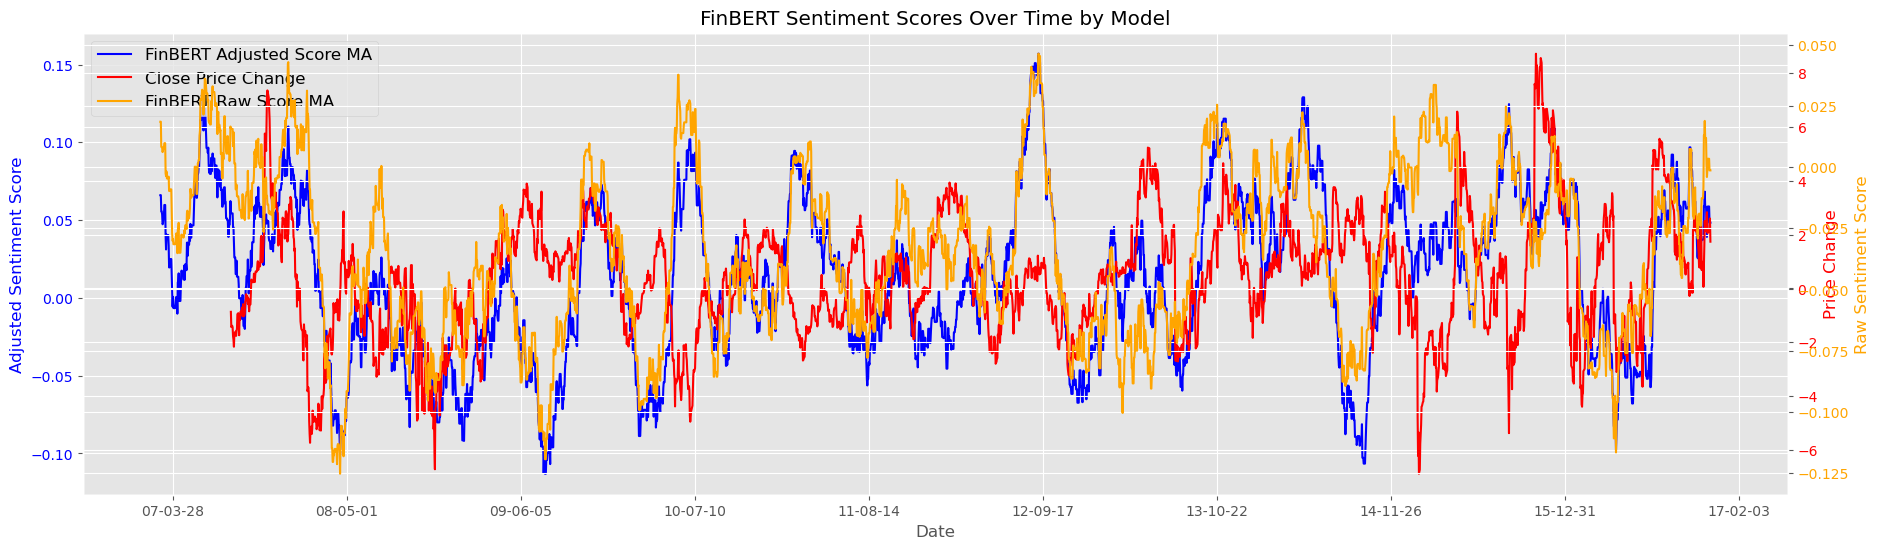

In [93]:
plot_sentiment_and_stock(msft_sentiment_plot, 'FinBERT', msft_stock_plot, 'close_diff')

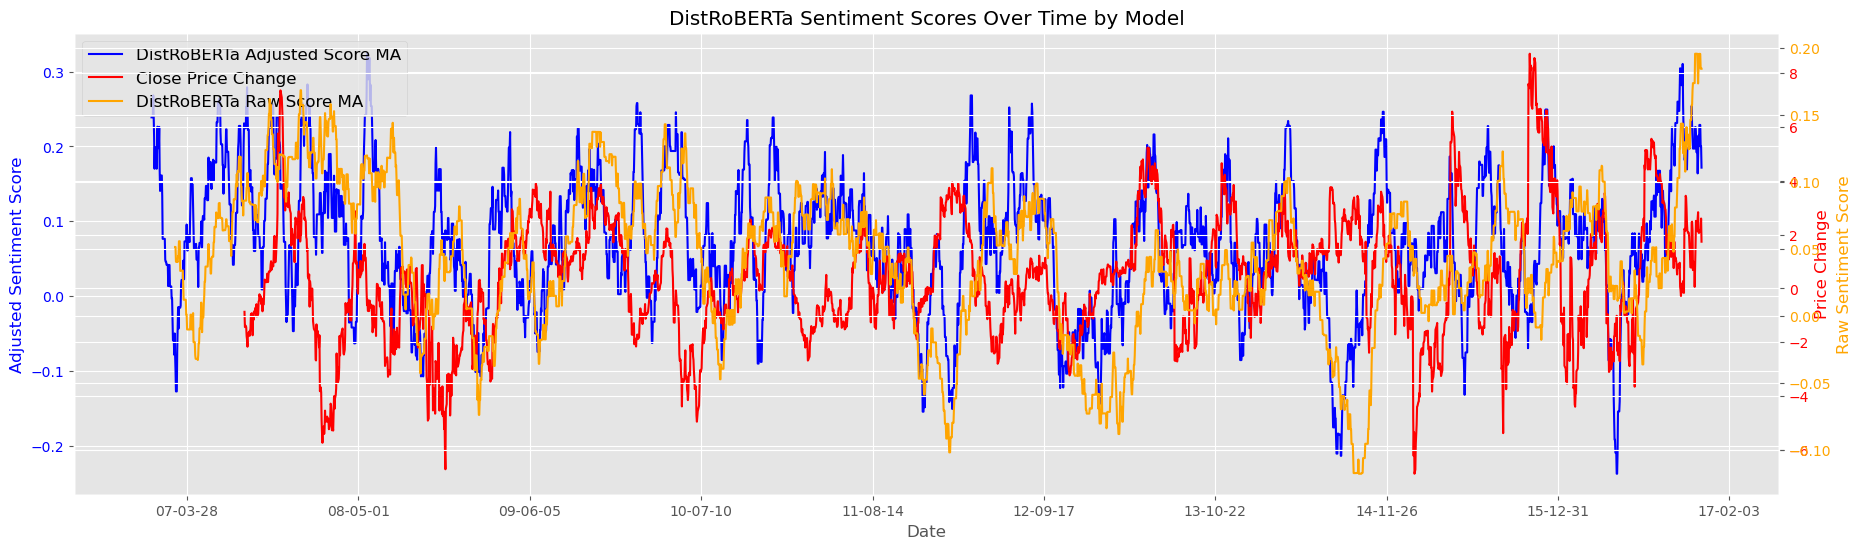

In [96]:
plot_sentiment_and_stock(msft_sentiment_plot, 'DistRoBERTa', msft_stock_plot, 'close_diff')

In [109]:
aapl_sentiment_plot = aapl_data.loc[:, ['Date', 'DeBERTa_adjusted_score', 'FinBERT_adjusted_score', 'DistRoBERTa_adjusted_score', 'trend_1d', 'DeBERTa_raw_score', 'FinBERT_raw_score', 'DistRoBERTa_raw_score']]
aapl_sentiment_plot['Date'] = pd.to_datetime(aapl_sentiment_plot['Date'])
aapl_sentiment_plot.set_index('Date', inplace=True)
aapl_sentiment_plot = aapl_sentiment_plot.resample('D').mean()
aapl_sentiment_plot.fillna(0, inplace=True)

In [124]:
aapl_sentiment_plot['DeBERTa_adjusted_score_ma'] = aapl_sentiment_plot['DeBERTa_adjusted_score'].rolling(window=90, center=False).mean()
aapl_sentiment_plot['FinBERT_adjusted_score_ma'] = aapl_sentiment_plot['FinBERT_adjusted_score'].rolling(window=90, center=False).mean()
aapl_sentiment_plot['DistRoBERTa_adjusted_score_ma'] = aapl_sentiment_plot['DistRoBERTa_adjusted_score'].rolling(window=90, center=False).mean()

aapl_sentiment_plot['DeBERTa_raw_score_ma'] = aapl_sentiment_plot['DeBERTa_raw_score'].rolling(window=90, center=False).mean()
aapl_sentiment_plot['FinBERT_raw_score_ma'] = aapl_sentiment_plot['FinBERT_raw_score'].rolling(window=90, center=False).mean()
aapl_sentiment_plot['DistRoBERTa_raw_score_ma'] = aapl_sentiment_plot['DistRoBERTa_raw_score'].rolling(window=90, center=False).mean()

In [126]:
aapl_stock_plot = aapl_data.loc[:, ['Date', 'Adj Close']]
aapl_stock_plot['Date'] = pd.to_datetime(aapl_stock_plot['Date'])
aapl_stock_plot.set_index('Date', inplace=True)
aapl_stock_plot = aapl_stock_plot.resample('D').mean()
aapl_stock_plot.fillna(method='ffill', inplace=True)
aapl_stock_plot['close_ma'] = aapl_stock_plot['Adj Close'].rolling(window=90, center=False).mean()
aapl_stock_plot['close_120_ma'] = aapl_stock_plot['Adj Close'].rolling(window=120, center=False).mean()
aapl_stock_plot['close_252_ma'] = aapl_stock_plot['Adj Close'].rolling(window=252, center=False).mean()
aapl_stock_plot.dropna(inplace=True)

aapl_stock_plot['close_diff'] = aapl_stock_plot['Adj Close'] - aapl_stock_plot['close_252_ma']

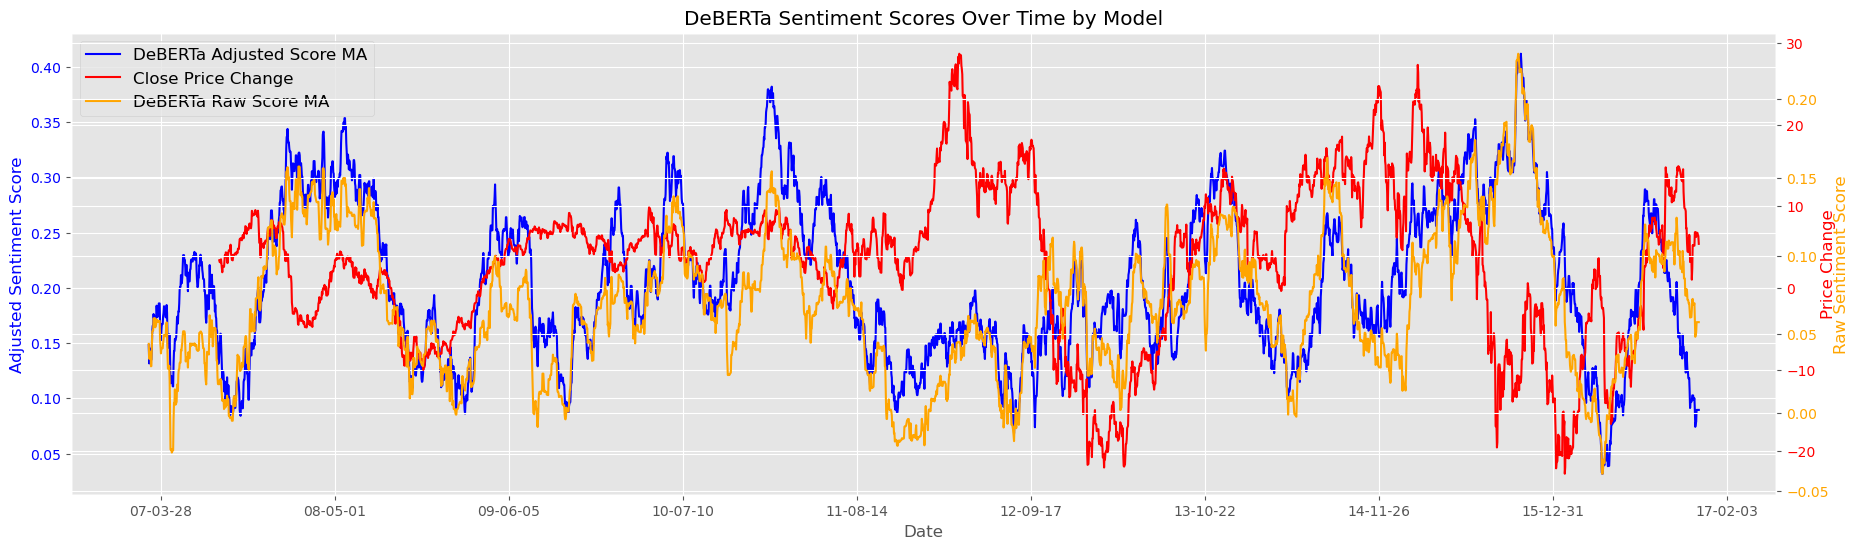

In [127]:
plot_sentiment_and_stock(aapl_sentiment_plot, 'DeBERTa', aapl_stock_plot, 'close_diff')

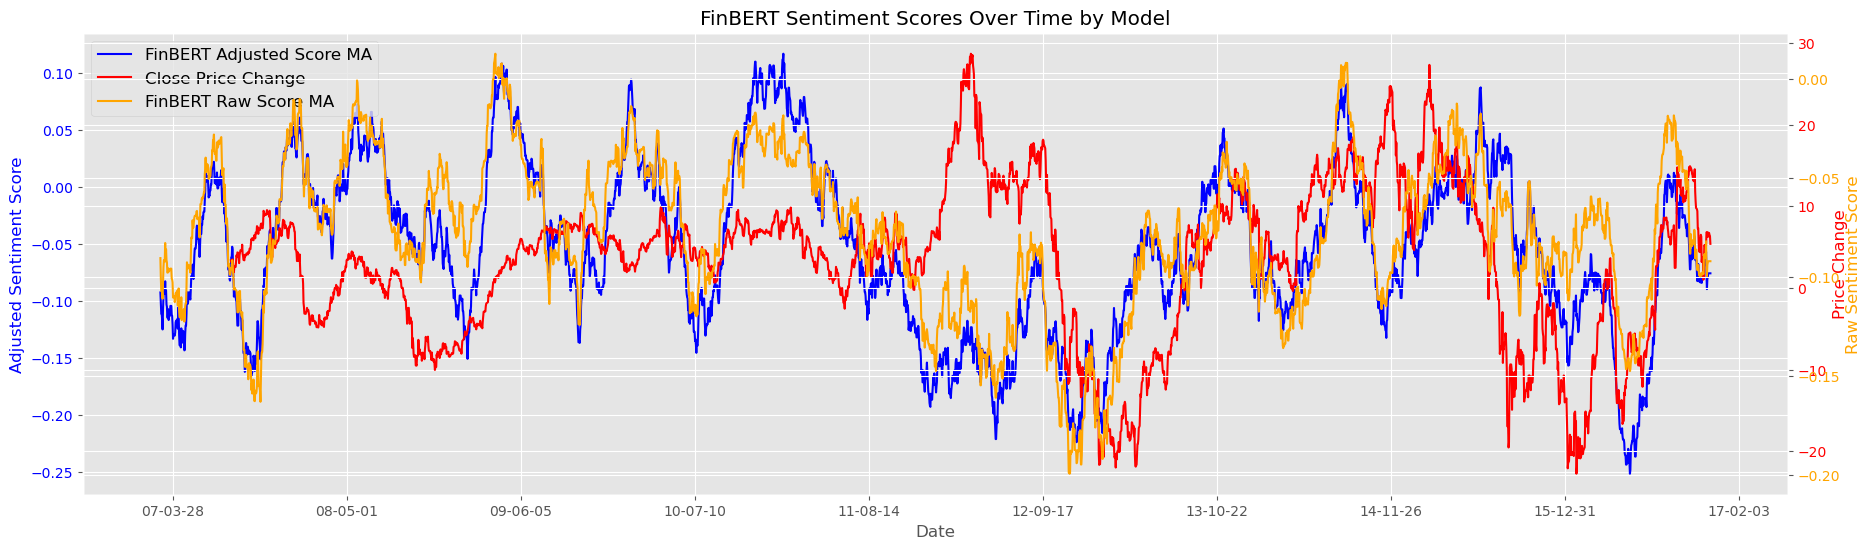

In [128]:
plot_sentiment_and_stock(aapl_sentiment_plot, 'FinBERT', aapl_stock_plot, 'close_diff')

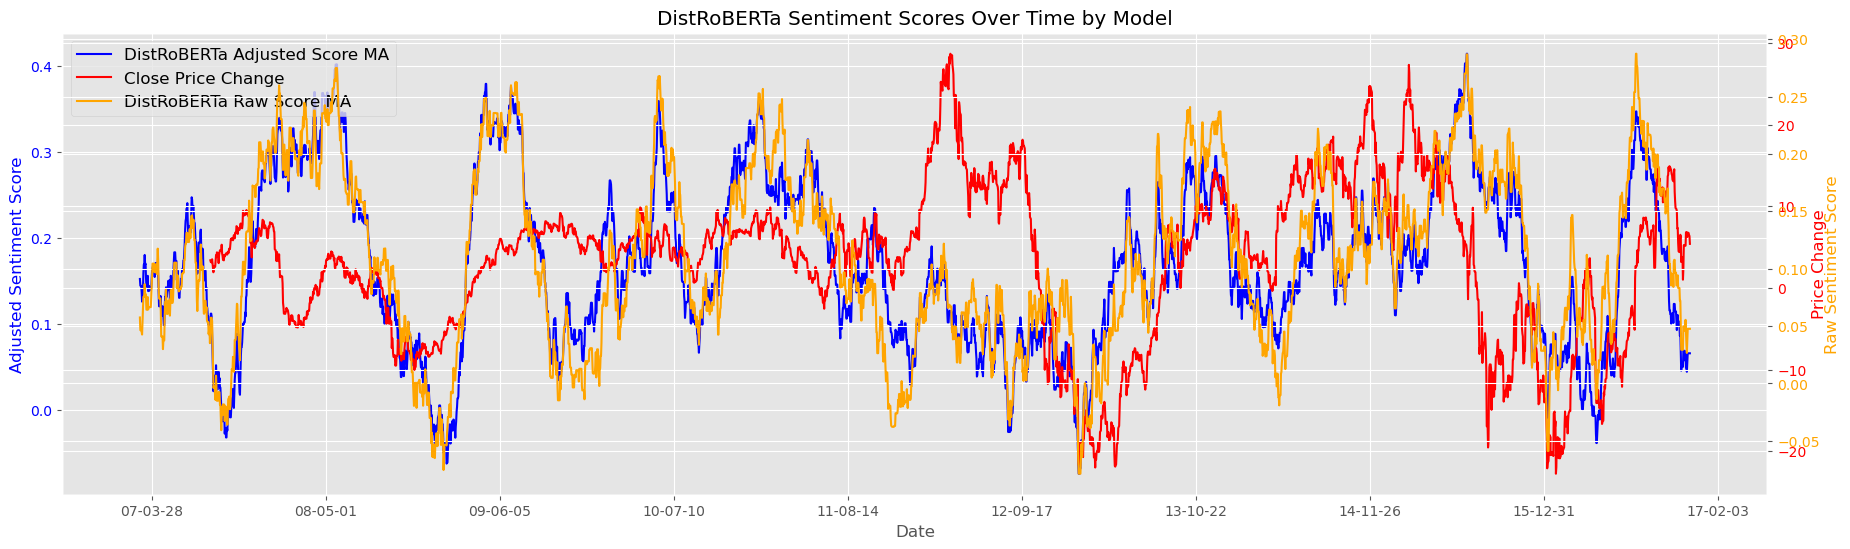

In [129]:
plot_sentiment_and_stock(aapl_sentiment_plot, 'DistRoBERTa', aapl_stock_plot, 'close_diff')

In [ ]:
msft_fig.write_image(file='/tmp/pycharm_project_520/src/data/output/Sentiment_Scores_Over_Time_by_Model.png', width=1200, height=600, engine='orca')

In [ ]:
filtered_data = msft_data[msft_data['DeBERTa_sentiment_score'] != 0]
filtered_data = filtered_data[filtered_data['DeBERTa_predictions'] == 1]
print(filtered_data[['Target', 'DeBERTa_sentiment_score', 'DeBERTa_predictions']])

In [ ]:
filtered_data = msft_data[msft_data['FinBERT_sentiment_score'] != 0]
filtered_data = filtered_data[filtered_data['FinBERT_predictions'] == 1]
print(filtered_data[['Target', 'FinBERT_sentiment_score', 'FinBERT_predictions']])

In [ ]:
filtered_data = msft_data[msft_data['DistRoBERTa_sentiment_score'] != 0]
filtered_data = filtered_data[filtered_data['DistRoBERTa_predictions'] == 1]
print(filtered_data[['Target', 'DistRoBERTa_sentiment_score', 'DistRoBERTa_predictions']])

## Testing ##

In [ ]:
# Prepare the data for plotting
scores_and_predictions = [
    ("DistRoBERTa_sentiment_score", "DistRoBERTa_predictions"),
    ("FinBERT_sentiment_score", "FinBERT_predictions"),
    ("DeBERTa_sentiment_score", "DeBERTa_predictions"),
]

plot_data = pd.DataFrame()

# Combine sentiment scores and their predictions into one DataFrame
for score, prediction in scores_and_predictions:
    temp_df = msft_data[["Date", score, prediction]].rename(
        columns={score: "Value", prediction: "Prediction"}
    )
    temp_df["Metric"] = score
    plot_data = pd.concat([plot_data, temp_df], ignore_index=True)

# Add a custom legend label combining type and prediction text
plot_data["Legend"] = plot_data.apply(
    lambda row: f"{row['Metric'].split('_')[0]} : {'true' if row['Prediction'] == 1 else 'false'}",
    axis=1,
)

# Assign distinct colors for each type-prediction combination
color_map = {
    "DistRoBERTa : false": "lightblue",
    "DistRoBERTa : true": "blue",
    "FinBERT : false": "lightgreen",
    "FinBERT : true": "green",
    "DeBERTa : false": "pink",
    "DeBERTa : true": "red",
}

# Map colors dynamically based on the Legend
plot_data["Color"] = plot_data["Legend"]

# Create the scatter plot
fig = px.scatter(
    plot_data,
    x="Date",
    y="Value",
    color="Legend",  # Map directly to 'Legend' for custom legend entries
    symbol="Metric",
    title="Sentiment Scores with Prediction-Based Colors",
    labels={"Value": "Sentiment Score", "Date": "Date", "Legend": "Type : Prediction", "Metric": "Metric"},
    color_discrete_map=color_map,
)

# Update layout for better visuals and make the plot wider
fig.update_xaxes(title_text="Date", tickangle=45)

# Set the legend title to "Type : Prediction"
fig.update_layout(
    legend_title_text="Type : Prediction",
    legend=dict(orientation="h", x=0.5, xanchor="center"),
    template="plotly_white",
    width=1200,  # Increase the width of the plot (default is 700)
)

# Adjust the size of the points (markers)
fig.update_traces(marker=dict(size=3))  # Set the size of the markers, 5 is a smaller size

# Show the plot
fig.show()


In [ ]:
fig = px.scatter(data_frame=msft_data,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=msft_data,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=msft_data,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='mrm8488_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='ProsusAI_sentiment_score', y='Target', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()

In [ ]:
fig = px.scatter(data_frame=aapl_data,
                 x='mrm8488_sentiment_score', y='ProsusAI_sentiment_score', template='plotly_white',
                 width=500, height=500, title='Target vs Sentiment Score result')

fig.update_traces(marker=dict(size=4,
                              line=dict(width=1,
                                        color='DarkSlateGrey')),
                  opacity=0.3,
                  selector=dict(mode='markers'))

fig.show()